In [1]:
#!pip install segmentation-models

In [2]:
import tensorflow as tf
import tifffile
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from sklearn.model_selection import train_test_split

import sys
import os
import datetime

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from skimage.measure import block_reduce
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [3]:
# only allocate what is needed (using for gpu memory testing)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
N = 2

# define the model
BACKBONE = 'resnet18'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

base_model = sm.Unet(BACKBONE, encoder_weights='imagenet')

inp = Input(shape =(None,None, N))
l1 = Conv2D(3,(1,1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model = Model(inp, out, name=base_model.name)
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
checkpoint_path = 'edf_to_gut_backresnet18_norm_patch_v1.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True,mode='min')
log_fname = 'edf_to_gut_backresnet18_norm_patch_v1.csv'
csvlogger = CSVLogger(filename=log_fname, separator=",", append=True)

In [5]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 2)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 3)     9         
_________________________________________________________________
model_1 (Model)              (None, None, None, 1)     14340570  
Total params: 14,340,579
Trainable params: 14,330,653
Non-trainable params: 9,926
_________________________________________________________________


In [7]:
model.load_weights('bfgreen_to_gmask_backresnet18_norm_patch_v1.h5')

In [11]:
folder_path = '../../31_gut_annot_withgreen'
imgs = tifffile.imread(os.path.join(folder_path, 'bf_only.tiff'))
imgs_g = tifffile.imread(os.path.join(folder_path, 'greenc_only.tiff'))
masks = tifffile.imread(os.path.join(folder_path, 'gutmask_only.tiff'))

In [12]:
def center_norm_im_float32(images):
    images_float = images.astype(np.float32)
    mean = np.mean(images_float)
    std = np.std(images_float)
    normalized_stack = (images_float-mean)/std
    return normalized_stack

def im_float32(images):
    images_float = images.astype(np.float32)
    return images_float

In [13]:
bf_imgs_norm = center_norm_im_float32(imgs)
g_imgs_norm = center_norm_im_float32(imgs_g)
mask_imgs = im_float32(masks)

In [14]:
combined_array = np.stack(( g_imgs_norm,bf_imgs_norm), axis=-1)
combined_array.shape

(31, 2048, 2048, 2)

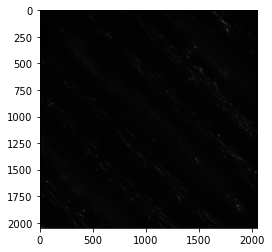

In [15]:
plt.imshow(combined_array[0,...,0], cmap='gray')

27


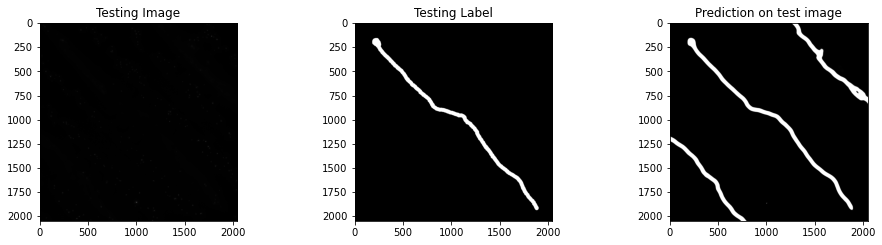

In [17]:
test_img_number = np.random.randint(0, bf_imgs_norm.shape[0])
print(test_img_number)
test_img = combined_array[test_img_number,...]

test_img_input=np.expand_dims(test_img, 0)
ground_truth=mask_imgs[test_img_number,...]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()